SER

In [ ]:
# 필요한 라이브러리 임포트
from transformers import BertModel, BertTokenizerFast
from torch.nn.functional import cosine_similarity
import re

# 토크나이저와 모델 로딩
tokenizer_bert = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
model_bert = BertModel.from_pretrained("kykim/bert-kor-base")

In [ ]:
# SER 측정에 사용할 함수들
def preprocess_text(text):
    """Remove punctuation and spaces from the text."""
    return re.sub(r'[,\.\s]', '', text)

def calculate_levenshtein_distance(s1, s2):
    """Levenshtein distance between two strings."""
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for index2, char2 in enumerate(s2):
        new_distances = [index2 + 1]
        for index1, char1 in enumerate(s1):
            if char1 == char2:
                new_distances.append(distances[index1])
            else:
                new_distances.append(1 + min((distances[index1], distances[index1 + 1], new_distances[-1])))
        distances = new_distances
    return distances[-1]

def calculate_ser(original_text, corrected_text):
    """Calculate the Syllable Error Rate (SER) between the original and corrected texts."""
    # Preprocess the texts to remove punctuation and spaces
    original_text = preprocess_text(original_text)
    corrected_text = preprocess_text(corrected_text)

    levenshtein_distance = calculate_levenshtein_distance(original_text, corrected_text)
    total_syllables = len(original_text)
    ser = levenshtein_distance / total_syllables
    return ser

In [ ]:
import pandas as pd
def add_data(df, original_text, stt_output, corrected_text, ser_ori_stt, ser_ori_cor, cosine_ori_stt, cosine_ori_cor):
    new_data = {
        'original_text': [original_text],
        'stt_output': [stt_output],
        'corrected_text': [corrected_text],
        'SER(ori, STT)': [ser_ori_stt],
        'SER(ori, Cor)': [ser_ori_cor],
        'Cosine(Ori, STT)': [cosine_ori_stt],
        'Cosine(ori, Cor)': [cosine_ori_cor]
    }
    new_df = pd.DataFrame(new_data)
    df = pd.concat([df, new_df], ignore_index=True)
    return df

In [ ]:
df = pd.DataFrame(columns=[
    'original_text',
    'stt_output',
    'corrected_text',
    'SER(ori, STT)',
    'SER(ori, Cor)',
    'Cosine(Ori, STT)',
    'Cosine(ori, Cor)'
])
df

,original_text,stt_output,corrected_text,"SER(ori, STT)","SER(ori, Cor)","Cosine(Ori, STT)","Cosine(ori, Cor)"


엑셀 파일의 경우

In [ ]:
# 엑셀 파일 경로
file_path = '/content/test_data.xlsx'

# 엑셀 파일을 읽어 데이터프레임으로 구성
df_data = pd.read_excel(file_path)

# 'user_content'와 'assistant_content' 컬럼의 데이터를 각각 리스트로 저장
questions = df_data['User content'].tolist()
origins = df_data['Assistant content'].tolist()

# 결과 출력
print("Questions:", questions)
print("Origin:", origins)

Questions: ['가족 폭력 문제로 인해 보호 명령을 받고 싶어요', '가족폭력 문제로 인해 보호 명령을 받고 싶어요', '가족폭력 문제로 인해 보호 명령을 받고 싶어요.', '가족폭력 문제로 인해 명령을 받고 싶어요 ', '간양 진단을 받아 수술이 필요해요 ', '간염 진단을 받아 수술이 필요해요', '하는 진단을 받아 수술이 필요해요', '안양 진단을 받아 수술이 필요해요', '고형주가 임금을 지급하지 않아서 소송을 고려하고 있어요 ', '고용주가 임금을 지급하지 않아서 고려하고 있어요', '고용주가 임금을 지급하지 않아서 소송을 그리하고 있어요.', '고용주가 임금을 지급하지 않아서 소송을 고려하고 있어요', '고혈압 때문에 걱정이에요', '고혈압 때문에 걱정이에요', '고혈압 때문에 걱정이에요', '고혈압 때문에 걱정이에요', '관절염 때문에 일하기가 힘들어요', '관절염 때문에 일하기가 힘들어', '관절염 때문에 일 하기가 힘들어요', '관절염 때문에 일 하기가 힘들어요', '단방비가 부담돼요', '난방비가 부담되어', '난방비가 부담되어', '난방비가 부담돼요', '남망 시설이 고장 났어요', '남방식 노래 고장 났어요', '안방 스토리 고장 났어요', '난방시설이 고장 났어요', '노숙자인데 임시 주고 지원이 필요해요', '노숙자인데 임시주거 지원이 필요해요', '노숙자인데 임시주거 지원이 필요해요', '노숙자인데 임시주거 지원이 필요해요', '가보나 가져는데 경제적 지원이 필요합니다', '다문화가정 아닌데 경제적 지원이 필요합니다', '아무나 과정인데 경제적 지원이 필요합니다.', '다문화가정인데 경제적 지원이 필요합니다', '당교 병이심해요', '당뇨병이 심해요', '당뇨병 심해요', '당뇨병 심해요', '백내장이 심해지고 있어요 ', '백내장에 심해지고 있어요', '백내장이 심해지고 있어요', '백내장에 심해지고', '범죄 피해자로서 피해 보상 청구 지원이 필요합니다', '범죄피해자로서 피해보상청구 조언이 필요합니다', '언제 피해자로서

jsonl 파일의 경우

In [2]:
import json

# 파일 경로
file_path = 'train_STT_test.jsonl'

# 질문과 답변을 저장할 리스트 초기화
questions = []
origins = []

# JSONL 파일을 읽고 각 라인을 파싱
with open(file_path, 'r', encoding='utf-8-sig') as file:
    for line in file:
        data = json.loads(line)
        for message in data['messages']:
            if message['role'] == 'user':
                questions.append(message['content'])
            elif message['role'] == 'assistant':
                origins.append(message['content'])

print("Questions:", questions)
print("Origin:", origins)


Questions: ['난방비를 못 내고 있어서 겨울에 난방을 사용할 수 없게 될까 봐 걱정이에요', ' 안 방귀를 못 내고 있어서 겨울에 난방을 사용할 수 없게 될까 봐 걱정이에요', ' 방귀를 못 낼 거 있어서 겨울에 난방을 사용할 수 없게 될까 봐 걱정이에요', ' 난방비를 못 내고 있어서 겨울에 난방을 사용할 수 없게 될까 봐 걱정이에요', ' 난방비를 못 내고 있어서 겨울에 난방을 사용할 수 없게 될까봐 정이에요', ' 한방 비를 못 내고 있어서 겨울에 난방을 사용할 수 없게 될까 봐 걱정이에요', ' 난방비를 못 내고 있어서 겨울에 난방을 사용할 수 없게 될까 봐 걱정이에요', ' 난방비를 못 내고 있어서 겨울에 난방을 사용할 수 없게 될까 봐 걱정이에요', ' 난방비를 못 내고 있어서 겨울에 난방을 사용할 수 없게 될까 봐 걱정이에요', '월급이 너무 적어서 생활비를 충당하기 어려워요', ' 월급이 너무 적어서 생활비를 충당하기 어려워요', ' 월급이 너무 작아서 생활비를 충당하기 어려워요', ' 월급이 너무 적어서 생활비를 충당하기 어려워요', ' 월급이 너무 적어서 생활비를 충당하기 어려워요', ' 월급이 너무 적어서 생활비를 충당하기 어려워요', ' 월급이 너무 작아서 생활비를 충당하기 어려워요', ' 알바비 너무 작아서 생활비를 충당하기 어려워요', ' 월급이 너무 적어서 생활비를 중단하기 어려워요', '면역력이 약해서 그런지 몸이 자주 아파요', ' 면역력이 약해서 그런지 몸이 자주 아파요', ' 안양 여기 약해서 그런지 몸이 자주 아파요', ' 정력이 약해서 그런지 몸이 자주 아파요', ' 면역력이 약해서 그런지 몸이 자주 아파요', ' 면역력이 약해서 그런지 몸이 자주 아파요', ' 면역력이 약해서 그런지 몸이 자주 아파요', ' 면역이 약해서 그런지 몸이 자주 아파요', ' 면역력이 약해서 그런지 몸이 자주 아파요', ' 면역력이 약해서 그런지 몸이 자주 아파요', '건강보험료를 못 내고 있어서 의료 혜택을 받을 수 없게 될까봐 걱정

In [ ]:
messages = [
    [{"role": "user", "content": question}] for question in questions
]

In [1]:
from openai import OpenAI
import os

filepath = os.path.abspath(__file__)
authpath = os.path.join(filepath, '..')

import auth_

key = auth_.openAIAuth()

NameError: name '__file__' is not defined

In [ ]:
for message, origin, question in zip(messages, origins, questions):
  response = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-1106:personal::9EdV2QBZ",
  messages= message,
  temperature=0.5, # temperature
  max_tokens=50,
  top_p=0.5, #top-p
  frequency_penalty=0,
  presence_penalty=0,
  stop=["\n\n"]
)
  original_text = origin
  stt_output = question
  corrected_text = response.choices[0].message.content
  contents = [original_text, stt_output, corrected_text]

  # 문장들을 인코딩하고 모델을 통해 임베딩 추출
  encoded_contents = [tokenizer_bert.encode_plus(content, return_tensors='pt', max_length=512, truncation=True, padding='max_length') for content in contents]
  embeddings = [model_bert(**encoded_input).last_hidden_state[:,0,:] for encoded_input in encoded_contents]  # `CLS` 토큰의 출력을 사용

  # SER 유사도 계산
  ser_1_2 = calculate_ser(contents[0], contents[1])
  ser_1_3 = calculate_ser(contents[0], contents[2])
  # 코사인 유사도 계산
  similarity_1_2 = cosine_similarity(embeddings[0], embeddings[1])
  similarity_1_3 = cosine_similarity(embeddings[0], embeddings[2])

  df = add_data(df, original_text, stt_output, corrected_text, ser_1_2, ser_1_3, similarity_1_2.item(), similarity_1_3.item())

df.to_excel('output.xlsx', index=False)
print("Dataframe saved to 'output.xlsx'")

Dataframe saved to 'output.xlsx'


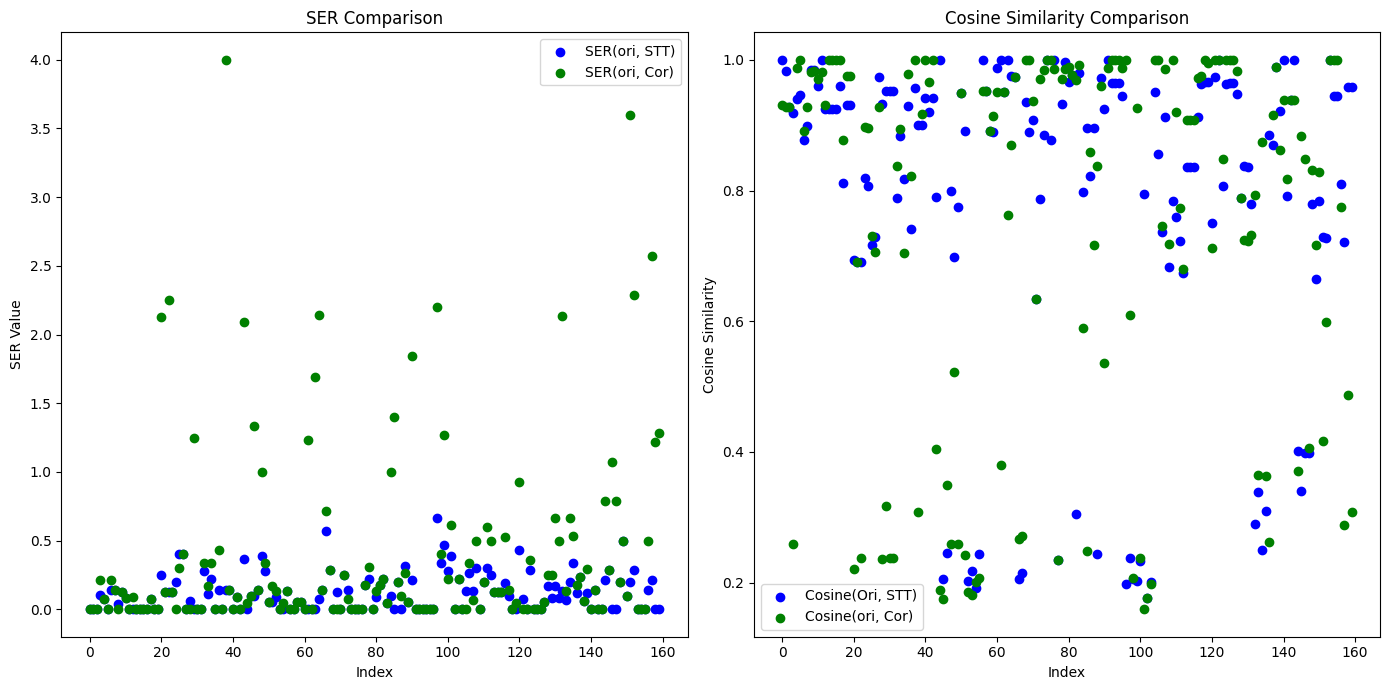

In [ ]:
import matplotlib.pyplot as plt

# 결과 엑셀 파일 경로
file_path = '/content/output_5_16.xlsx'

# 엑셀 파일을 읽어 데이터프레임으로 구성
df = pd.read_excel(file_path)

# 점 그래프 그리기
plt.figure(figsize=(14, 7))

# SER 점 그래프
plt.subplot(1, 2, 1)
plt.scatter(df.index, df['SER(ori, STT)'], label='SER(ori, STT)', color='blue')
plt.scatter(df.index, df['SER(ori, Cor)'], label='SER(ori, Cor)', color='green')
plt.xlabel('Index')
plt.ylabel('SER Value')
plt.title('SER Comparison')
plt.legend()

# Cosine 유사도 점 그래프
plt.subplot(1, 2, 2)
plt.scatter(df.index, df['Cosine(Ori, STT)'], label='Cosine(Ori, STT)', color='blue')
plt.scatter(df.index, df['Cosine(ori, Cor)'], label='Cosine(ori, Cor)', color='green')
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Comparison')
plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()


출력 예시
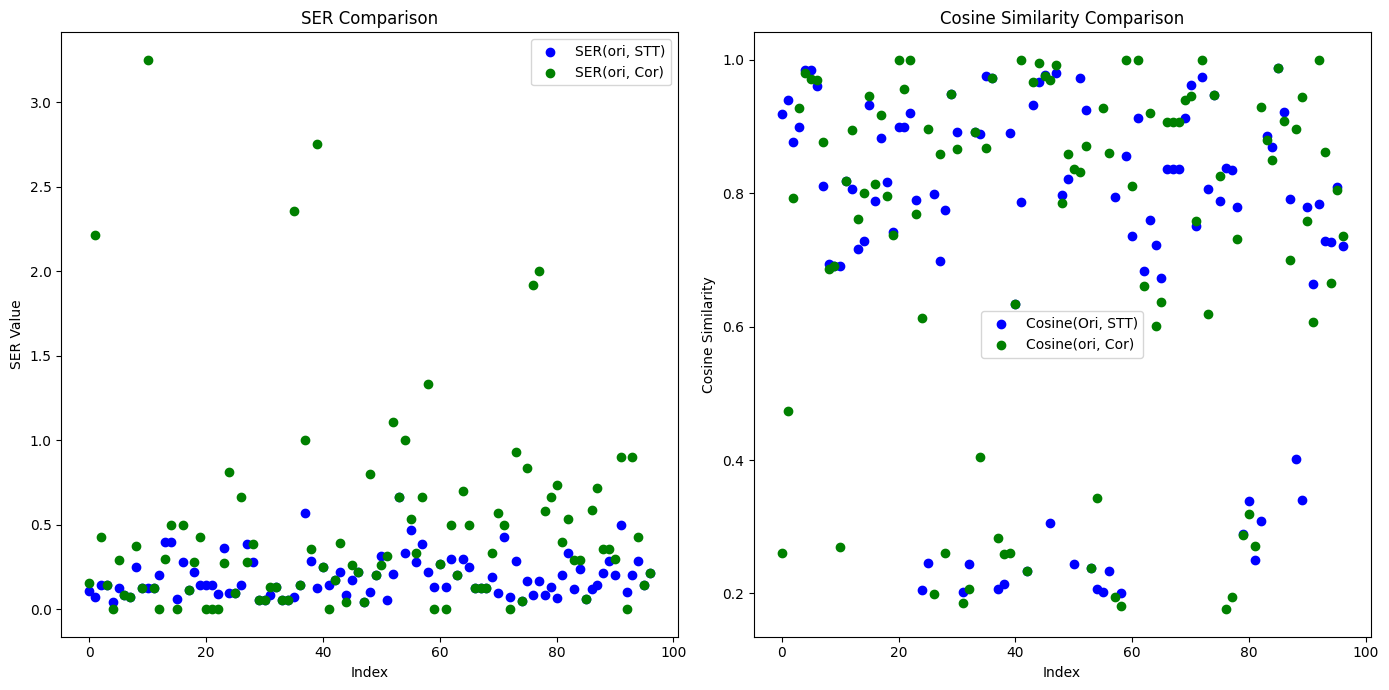

In [ ]:
# Define bins for SER and Cosine values
ser_bins = [i * 0.1 for i in range(11)]
cosine_bins = [i * 0.1 for i in range(11)]

# Calculate the histogram for SER and Cosine values
ser_ori_stt_hist = pd.cut(df['SER(ori, STT)'], bins=ser_bins).value_counts().sort_index()
ser_ori_cor_hist = pd.cut(df['SER(ori, Cor)'], bins=ser_bins).value_counts().sort_index()
cosine_ori_stt_hist = pd.cut(df['Cosine(Ori, STT)'], bins=cosine_bins).value_counts().sort_index()
cosine_ori_cor_hist = pd.cut(df['Cosine(ori, Cor)'], bins=cosine_bins).value_counts().sort_index()

# Create bar plots for SER and Cosine histograms
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

# Bar plot for SER histograms
axes[0].bar(ser_ori_stt_hist.index.astype(str), ser_ori_stt_hist, width=0.4, label='SER(ori, STT)', color='blue')
axes[0].bar(ser_ori_cor_hist.index.astype(str), ser_ori_cor_hist, width=0.4, label='SER(ori, Cor)', alpha=0.7, color='green')
axes[0].set_title('SER Distribution')
axes[0].set_xlabel('SER Range')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(True)

# Bar plot for Cosine histograms
axes[1].bar(cosine_ori_stt_hist.index.astype(str), cosine_ori_stt_hist, width=0.4, label='Cosine(Ori, STT)', color='blue')
axes[1].bar(cosine_ori_cor_hist.index.astype(str), cosine_ori_cor_hist, width=0.4, label='Cosine(ori, Cor)', alpha=0.7, color='green')
axes[1].set_title('Cosine Similarity Distribution')
axes[1].set_xlabel('Cosine Similarity Range')
axes[1].set_ylabel('Count')
axes[1].legend()
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

# Display the bar plots
plt.show()


출력 예시
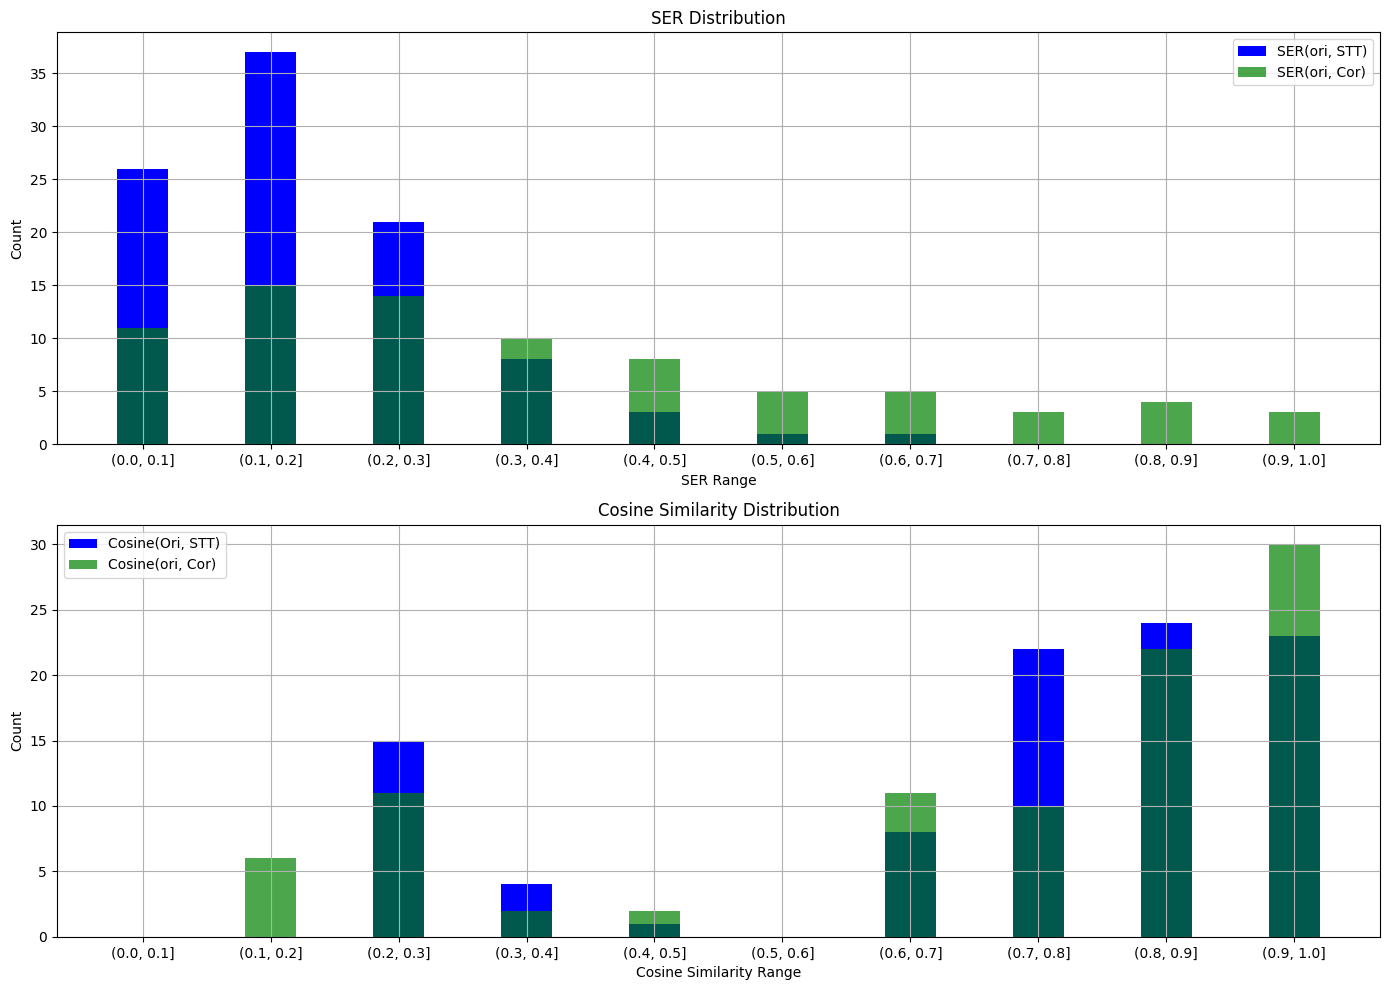